<a href="https://colab.research.google.com/github/igorszt/Previsao-Resultado-Campeonato-Brasileiro-2022/blob/main/PrevendoResultadosBrasileirao2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Previsão dos resultados do Brasileirão 2022 utilizando os jogos do Brasileirão 2021.

In [1]:
#importar bibliotecas
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#lendo o arquivo BRA.csv
#O arquivo utilizado foi baixado do site www.football-data.co.uk, que agrega informações de diversos campeonatos
#ao redor do mundo.

data=pd.read_csv('BRA.csv')

#Descrição das colunas
#Country = país do campeonato
#League = nome da liga
#game_id = id do jogo
#Season = temporada
#date = data do jogo
#Time = hora do jogo
#Home = Time da casa
#home_id = id do time da casa
#Away = time visitante
#Away_id =  id do time visitante
#HG = Gols do time da casa
#AG = Gols do time visitante
#Res = Resultado do jogo (D=draw, H=Home win, A=Away win)
#PH = probablidade vitória time da casa provida pela Pinacle (casa de aposta inglesa)
#PD = probablidade empate provida pela Pinacle (casa de aposta inglesa)
#PA = probablidade vitória time visitante provida pela Pinacle (casa de aposta inglesa)
#MaxH = probablidade vitória time da casa provida pela OddsPortal (casa de aposta inglesa)
#MaxD = probablidade empate provida pela OddsPortal (casa de aposta inglesa)
#MaxA = probablidade vitória time visitante provida pela OddsPortal (casa de aposta ingles
#AvgH = probablidade média de vitória em casa provida pela OddsPortal (casa de aposta inglesa)
#AvgD = probablidade média de empate provida pela OddsPortal (casa de aposta inglesa)
#AvgA = probablidade média de vitória pelo time visitante provida pela OddsPortal (casa de aposta inglesa)

#Verificando as 5 primeiras linhas do arquivo a ser utilizado
data.head()

,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,Brazil,Serie A,2012,19/05/2012,22:30,Palmeiras,Portuguesa,1.0,1.0,D,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90
1,Brazil,Serie A,2012,19/05/2012,22:30,Sport Recife,Flamengo RJ,1.0,1.0,D,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58
2,Brazil,Serie A,2012,20/05/2012,01:00,Figueirense,Nautico,2.0,1.0,H,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64
3,Brazil,Serie A,2012,20/05/2012,20:00,Botafogo RJ,Sao Paulo,4.0,2.0,H,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84
4,Brazil,Serie A,2012,20/05/2012,20:00,Corinthians,Fluminense,0.0,1.0,A,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89


In [3]:
# como a base de dados contempla todos os resultados dos jogos do brasileirão desde 2012, vamos selecionar somente os anos de 2021 e 2022
#vamos treinar o modelo com o ano de 2021 e o ano de 2022 será o de previsão
values=[2021,2022]
data_2021 = data[data['Season']==values[0]]
data_2022 = data[data['Season']==values[1]]

In [4]:
data_2021.shape

(380, 19)

In [5]:
data_2021.dtypes

Country     object
League      object
Season       int64
Date        object
Time        object
Home        object
Away        object
HG         float64
AG         float64
Res         object
PH         float64
PD         float64
PA         float64
MaxH       float64
MaxD       float64
MaxA       float64
AvgH       float64
AvgD       float64
AvgA       float64
dtype: object

In [6]:
#verificando valores nulos
data_2021.isna().sum()

Country    0
League     0
Season     0
Date       0
Time       0
Home       0
Away       0
HG         0
AG         0
Res        0
PH         0
PD         0
PA         0
MaxH       0
MaxD       0
MaxA       0
AvgH       0
AvgD       0
AvgA       0
dtype: int64

In [7]:
#Explorando os dados
#Base de dados de dos campeonatos de 2012 a 2022

partidas = data_2021.shape[0]

variaveis = data_2021.shape[1] #Retirando a coluna Resultado

vitorias_casa = len(data_2021[data_2021.Res=='H'])
vitorias_fora = len(data_2021[data_2021.Res=='A'])
empate = len(data_2021[data_2021.Res=='D'])
val=[vitorias_casa,vitorias_fora,empate]

vitoria_casa_pct = (float(vitorias_casa)/(partidas)) *100

print ('Total de jogos: ', partidas)
print ('Total de colunas: ', variaveis)
print ('Total de jogos ganhos em casa: ', vitorias_casa)
print ('Total de jogos ganhos pelo visitante: ', vitorias_fora)
print ('Total de jogos empatados: ', empate)
print ('Percentual de jogos ganhos em casa: {:.2f}%'.format( vitoria_casa_pct ))

#Podemos notar que o "fator casa" é importante , sendo que em aproximadamente 45% dos jogos são ganhos pelo time da casa.

Total de jogos:  380
Total de colunas:  19
Total de jogos ganhos em casa:  174
Total de jogos ganhos pelo visitante:  93
Total de jogos empatados:  113
Percentual de jogos ganhos em casa: 45.79%


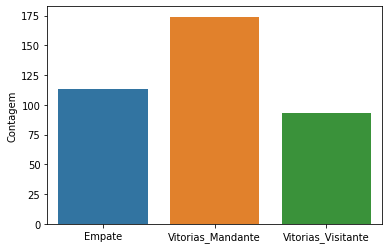

In [8]:
#Visualizando os dados
data_2021['Res'] = data_2021['Res'].replace(['D','H','A'],['Empate','Vitorias_Mandante','Vitorias_Visitante'])
sns.countplot(data_2021['Res'])
plt.xlabel('');
plt.ylabel('Contagem');

In [9]:
#Preparando os dados

#Deixar somente as variáveis numericas 
data_numerica = data_2021.drop(['Country','League','Season','Date','Time','Home','Away'],1)

In [10]:
#separa as features 
#data_numerica['Res'] = data_numerica['Res'].replace(['Empate','Vitorias_Mandante','Vitorias_Visitante'],[0,1,2])
variaveis_preditoras = data_numerica.drop(['Res'],1)

#variavel target
variavel_target = data_numerica['Res']

print('Variáveis Preditoras')
print (variaveis_preditoras.head())

print ('Variável Target')
print (variavel_target.head())

Variáveis Preditoras
       HG   AG    PH    PD    PA  MaxH  MaxD  MaxA  AvgH  AvgD  AvgA
3420  2.0  2.0  2.27  3.11  3.69  2.27  3.25  3.79  2.21  3.06  3.51
3421  3.0  0.0  2.49  3.13  3.20  2.53  3.41  3.21  2.36  3.15  3.09
3422  0.0  0.0  1.87  3.26  5.16  1.97  3.50  5.31  1.90  3.12  4.65
3423  1.0  2.0  1.48  4.42  7.31  1.53  4.42  8.10  1.47  4.14  6.98
3424  3.0  2.0  3.74  3.23  2.19  3.91  3.29  2.23  3.62  3.09  2.16
Variável Target
3420                Empate
3421     Vitorias_Mandante
3422                Empate
3423    Vitorias_Visitante
3424     Vitorias_Mandante
Name: Res, dtype: object


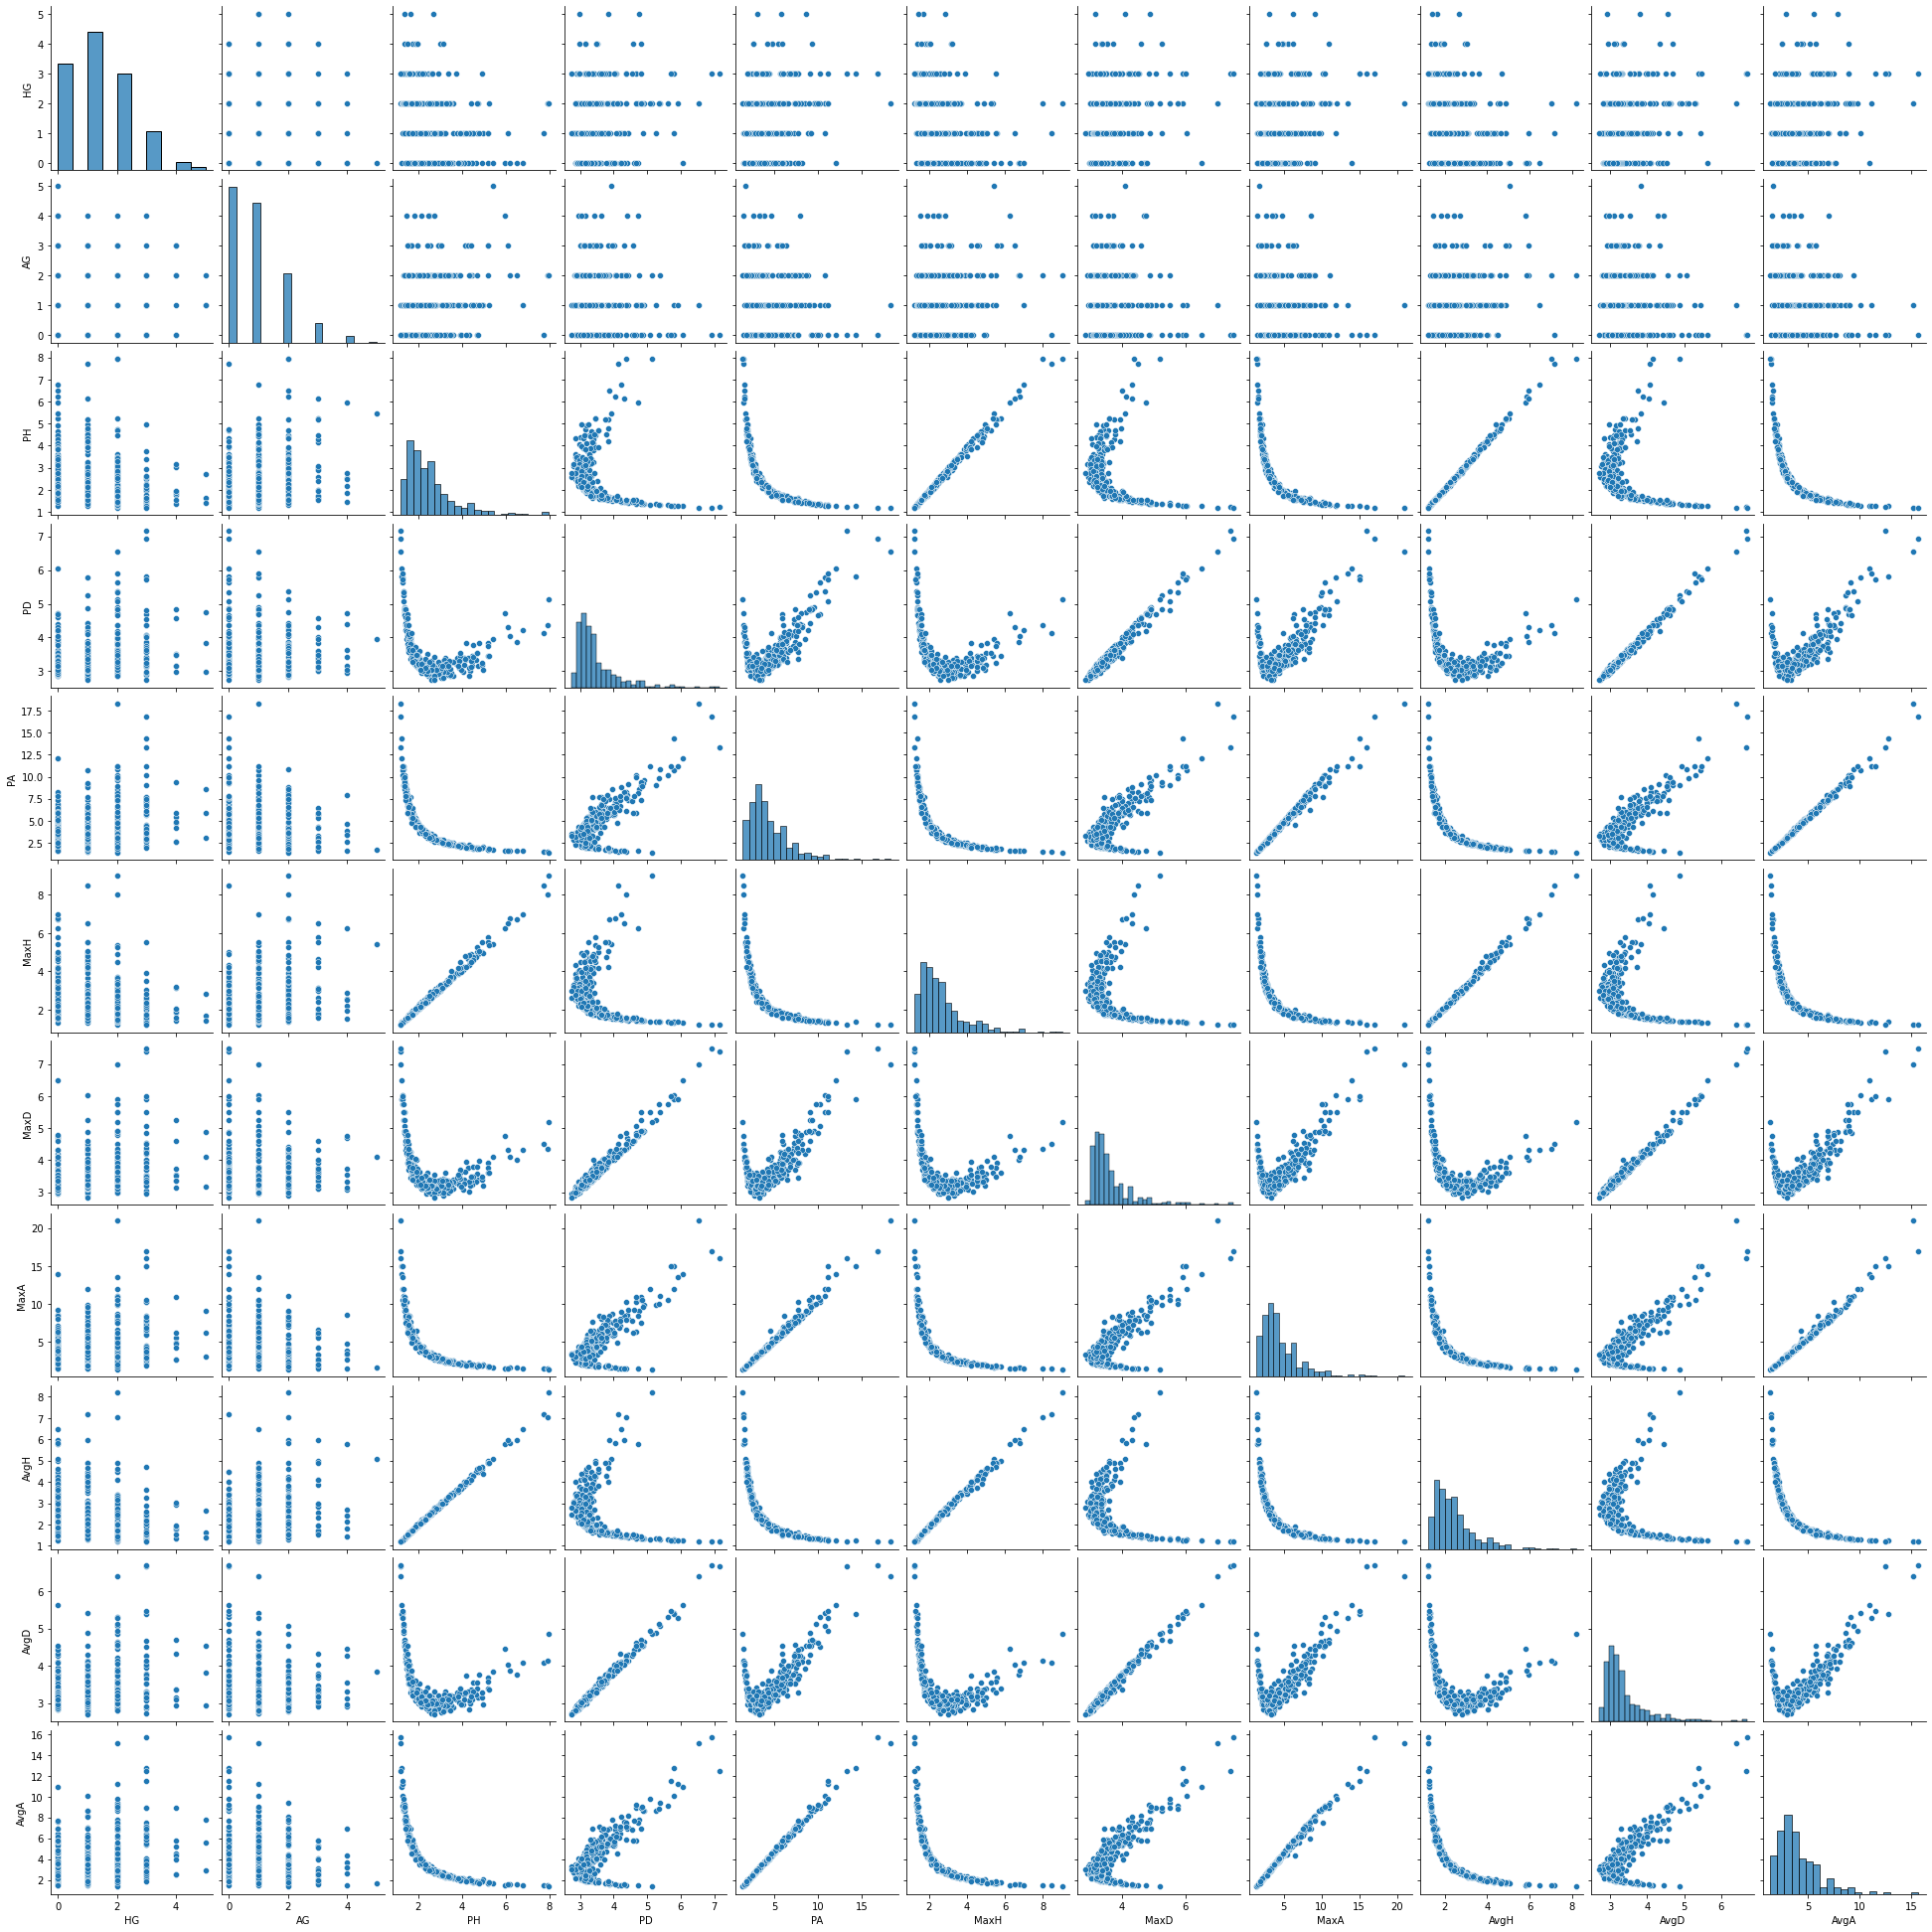

In [11]:
#histograma das variaveis preditoras
sns.pairplot(variaveis_preditoras)

In [12]:
#Analisando as melhores features com Kbest

from sklearn.feature_selection import chi2
variaveis_preditoras_colunas = variaveis_preditoras.columns
# # Extração de Variáveis
teste = SelectKBest(score_func = chi2, k = 'all')
teste.fit_transform(variaveis_preditoras,variavel_target)
teste_scores = teste.scores_
scores = zip(variaveis_preditoras_colunas[:],teste_scores)
print(list(scores))

[('HG', 143.46809148475532), ('AG', 156.48834911038878), ('PH', 17.09435534986931), ('PD', 0.8389970104968979), ('PA', 35.62946797911189), ('MaxH', 18.005310222487974), ('MaxD', 1.0573265307224053), ('MaxA', 39.34392581190534), ('AvgH', 15.355861180815204), ('AvgD', 0.7670608380951531), ('AvgA', 31.009100012974088)]


In [13]:
# Nota-se que as variaveis preditoras 'PD', 'MaxD' e 'AvgD' apresentaram os piores scores, logo iremos exclui-las no treinamento do modelo.
variaveis_preditoras = data_numerica.drop(['Res','PD','MaxD','AvgD'],1)
variaveis_preditoras.head()

,HG,AG,PH,PA,MaxH,MaxA,AvgH,AvgA
3420,2.0,2.0,2.27,3.69,2.27,3.79,2.21,3.51
3421,3.0,0.0,2.49,3.20,2.53,3.21,2.36,3.09
3422,0.0,0.0,1.87,5.16,1.97,5.31,1.90,4.65
3423,1.0,2.0,1.48,7.31,1.53,8.10,1.47,6.98
3424,3.0,2.0,3.74,2.19,3.91,2.23,3.62,2.16


In [14]:
#Aplicar normalizacao nos dados

escala = MinMaxScaler().fit(variaveis_preditoras)
variaveis_preditoras_escala = escala.transform(variaveis_preditoras)

print ('Variáveis Preditoras Normalizadas: ',variaveis_preditoras_escala.shape)
print (variaveis_preditoras_escala)

Variáveis Preditoras Normalizadas:  (380, 8)
[[0.4        0.4        0.15976331 ... 0.12149056 0.14592275 0.15034965]
 [0.6        0.         0.19230769 ... 0.09188361 0.16738197 0.12097902]
 [0.         0.         0.10059172 ... 0.19908116 0.10157368 0.23006993]
 ...
 [0.2        0.         0.44674556 ... 0.02756508 0.40200286 0.03426573]
 [0.2        0.2        0.13609467 ... 0.15518121 0.12589413 0.19090909]
 [0.2        0.2        0.08284024 ... 0.21388464 0.07439199 0.26783217]]


In [15]:
variaveis_preditoras_escala.shape

(380, 8)

In [16]:
variavel_target.shape

(380,)

In [17]:
#separando dados de treino e teste
# de 100% dos dados = 70% treino, 30%teste

x_treino,x_teste,y_treino,y_teste = train_test_split(variaveis_preditoras_escala,variavel_target,test_size = 0.3,random_state=1)

In [18]:
x_treino.shape

(266, 8)

In [19]:
x_teste.shape

(114, 8)

In [20]:
# Treinando e avaliando os modelos
#Logistic Regression

Log_Reg = LogisticRegression()
Log_Reg.fit(x_treino,y_treino)
previsao=Log_Reg.predict(x_teste)

acuracia = accuracy_score(y_teste, previsao)
report = classification_report(y_teste, previsao)
print(report)
print ('Acurácia Modelo LogisticRegression:{:.2f} %'.format(acuracia*100))

                    precision    recall  f1-score   support

            Empate       0.78      0.85      0.81        33
 Vitorias_Mandante       0.93      1.00      0.96        53
Vitorias_Visitante       0.95      0.71      0.82        28

          accuracy                           0.89       114
         macro avg       0.89      0.85      0.86       114
      weighted avg       0.89      0.89      0.88       114

Acurácia Modelo LogisticRegression:88.60 %


In [21]:
#Testando LogisticRegression com Ajuste de Parâmetros

parametros = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

grid = GridSearchCV(estimator = LogisticRegression(), param_grid = parametros,cv = 9)

grid.fit(x_treino,y_treino)
pd.DataFrame(grid.cv_results_)
clf = grid.best_estimator_
previsao = clf.predict(x_teste)

acuracia = accuracy_score(y_teste, previsao)
report = classification_report(y_teste, previsao)
print(report)
print ('Acurácia Modelo LogisticRegression com Ajuste de Parametros:{:.2f} %'.format(acuracia*100))

# f1=f1_score(y_test,pred,average = 'macro')

# print ('Acurácia LogisticRegression:{}'.format(lg_acc))
# print ('F1 Score:{}'.format(f1) )

# print (clf)

                    precision    recall  f1-score   support

            Empate       1.00      1.00      1.00        33
 Vitorias_Mandante       1.00      1.00      1.00        53
Vitorias_Visitante       1.00      1.00      1.00        28

          accuracy                           1.00       114
         macro avg       1.00      1.00      1.00       114
      weighted avg       1.00      1.00      1.00       114

Acurácia Modelo LogisticRegression com Ajuste de Parametros:100.00 %


In [22]:
#Treinando e testando os modelos
#Arvore de decisão

Arv_Dec = DecisionTreeClassifier()
Arv_Dec.fit(x_treino,y_treino)
previsao = Arv_Dec.predict(x_teste)

acuracia = accuracy_score(y_teste, previsao)
report = classification_report(y_teste, previsao)
print(report)
print ('Acurácia Modelo Árvore de Decisão:{:.2f} %'.format(acuracia*100))

                    precision    recall  f1-score   support

            Empate       1.00      0.97      0.98        33
 Vitorias_Mandante       0.98      1.00      0.99        53
Vitorias_Visitante       1.00      1.00      1.00        28

          accuracy                           0.99       114
         macro avg       0.99      0.99      0.99       114
      weighted avg       0.99      0.99      0.99       114

Acurácia Modelo Árvore de Decisão:99.12 %


In [23]:
#Treinando e testando os modelos
#SVC

Modelo_SVC = SVC()
Modelo_SVC.fit(x_treino,y_treino)
previsao = Modelo_SVC.predict(x_teste)

acuracia = accuracy_score(y_teste, previsao)
report = classification_report(y_teste, previsao)
print(report)
print ('Acurácia Modelo SVC:{:.2f} %'.format(acuracia*100))

                    precision    recall  f1-score   support

            Empate       0.97      1.00      0.99        33
 Vitorias_Mandante       1.00      0.98      0.99        53
Vitorias_Visitante       1.00      1.00      1.00        28

          accuracy                           0.99       114
         macro avg       0.99      0.99      0.99       114
      weighted avg       0.99      0.99      0.99       114

Acurácia Modelo SVC:99.12 %


In [25]:
#Executando a previsao dos jogos do Brasileirão 2022

data_2022['Res'] = data_2022['Res'].replace(['D','H','A'],['Empate','Vitorias_Mandante','Vitorias_Visitante'])
data_numerica_2022 = data_2022.drop(['Country','League','Season','Date','Time','Home','Away'],1)

variaveis_preditoras_2022 = data_numerica_2022.drop(['Res'],1)

#variavel target
variavel_target_2022 = data_numerica_2022['Res']

variaveis_preditoras_2022 = data_numerica_2022.drop(['Res','PD','MaxD','AvgD'],1)

escala_2022 = MinMaxScaler().fit(variaveis_preditoras_2022)
variaveis_preditoras_escala_2022 = escala_2022.transform(variaveis_preditoras_2022)

previsao_2022 = Modelo_SVC.predict(variaveis_preditoras_escala_2022)

df=pd.DataFrame({'real': variavel_target_2022, 'previsao':previsao_2022})

print(df)

                    real            previsao
3800              Empate              Empate
3801              Empate  Vitorias_Visitante
3802  Vitorias_Visitante  Vitorias_Visitante
3803   Vitorias_Mandante   Vitorias_Mandante
3804   Vitorias_Mandante   Vitorias_Mandante
3805  Vitorias_Visitante  Vitorias_Visitante
3806  Vitorias_Visitante  Vitorias_Visitante
3807   Vitorias_Mandante   Vitorias_Mandante
3808   Vitorias_Mandante   Vitorias_Mandante
3809              Empate  Vitorias_Visitante
3810              Empate              Empate
3811   Vitorias_Mandante   Vitorias_Mandante
3812   Vitorias_Mandante   Vitorias_Mandante
3813  Vitorias_Visitante  Vitorias_Visitante
3814   Vitorias_Mandante   Vitorias_Mandante
3815   Vitorias_Mandante   Vitorias_Mandante
3816  Vitorias_Visitante  Vitorias_Visitante
3817   Vitorias_Mandante   Vitorias_Mandante
3818   Vitorias_Mandante   Vitorias_Mandante
3819  Vitorias_Visitante  Vitorias_Visitante
3820              Empate              Empate
3821   Vit

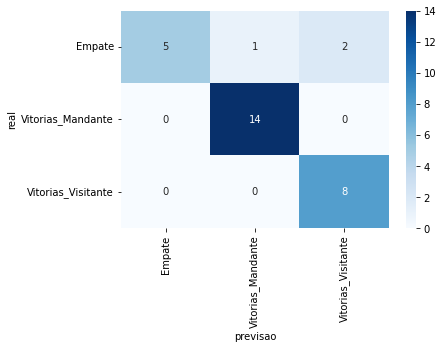

In [26]:
#matriz confusao

df=pd.DataFrame(df,columns=['real','previsao' ])

cf_matrix=pd.crosstab(df['real'], df['previsao'], rownames=['real'] , colnames=['previsao'])

sns.heatmap(cf_matrix, annot=True, cmap='Blues')